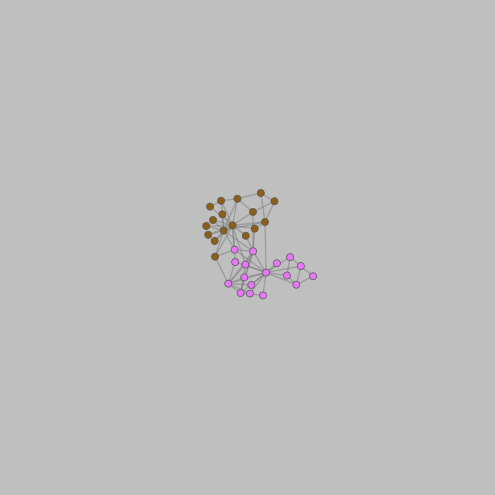

In [2]:
%matplotlib inline
import networkx as nx
import netwulf as nw
import matplotlib.pyplot as plt

#Create graph and get node attributes for nw:
G = nx.karate_club_graph()
for k, v in G.nodes(data=True):
    v['group'] = v['club']; del v['club']

with plt.style.context('classic'):
    network, config = nw.interactive.visualize(G, plot_in_cell_below=False)
    fig, ax = nw.draw_netwulf(network)

In [4]:
import networkx as nx
import netwulf as nw
import matplotlib.pyplot as plt

G = nx.karate_club_graph()
for k, v in G.nodes(data=True):
    v['group'] = v['club']; del v['club']



def modularity(G: G, partitioning: list) -> float:
    L = len(G.edges())
    M = 0
    for partion in partitioning:
        subgraph = G.subgraph(partion).copy()
        L_c = subgraph.number_of_edges()
        K_c = sum(G.degree[node] for node in subgraph.nodes())
        M += (L_c/L) - (K_c/(2*L))**2
    return M

In [5]:
import random

nG = G.copy()

N = 100
for i in range(N):
    edges = list(nx.edges(nG))
    drawn = random.choices(edges, k=2)
    
    if drawn[0][0] == drawn[0][1]:
        pass
    if drawn[0][1] == drawn[1][0]:
        pass
    
    if (drawn[0][0],drawn[1][1]) not in edges and (drawn[1][0],drawn[0][1]) not in edges:
        nG.add_edge(drawn[0][0], drawn[1][1])
        nG.add_edge(drawn[1][0], drawn[0][1])
        if (drawn[0][0],drawn[0][1]) in edges:
            nG.remove_edge(drawn[0][0],drawn[0][1])
        if (drawn[1][0],drawn[1][1]) in edges:            
            nG.remove_edge(drawn[1][0],drawn[1][1])


In [6]:
nG

In [55]:
from tqdm import tqdm
import numpy as np
np.random.seed(0)
def modularity(G, partitioning: list) -> float:
    L = len(G.edges())
    M = 0
    for partion in partitioning:
        subgraph = G.subgraph(partion).copy()
        L_c = subgraph.number_of_edges()
        K_c = sum(G.degree[node] for node in subgraph.nodes())
        M += (L_c/L) - (K_c/(2*L))**2
    return M

def double_edge_swap(G: G, N: int)->G:
    G_random = G.copy()
    num_swaps = 0
    keys, degrees = zip(*G_random.degree())
    cdf = nx.utils.cumulative_distribution(degrees)  # cdf of degree
    discrete_sequence = nx.utils.discrete_sequence
    while num_swaps < N:

        (u_idx, x_idx) = discrete_sequence(2, cdistribution=cdf) #Draw indices with respect to our cdf of degree
        if u_idx == x_idx: #Same source, skip
            continue
        u = keys[u_idx]  #Convert index to label
        x = keys[x_idx]

        v = random.choice(list(G_random.neighbors(u))) #Draw randomly from the neighboring nodes
        y = random.choice(list(G_random.neighbors(x)))

        if v==y: #Same target, skip
            continue
        if (x not in G_random.neighbors(u)) and (y not in G_random.neighbors(v)):
            G_random.add_edge(u, x)
            G_random.add_edge(v, y)
            G_random.remove_edge(u, v)
            G_random.remove_edge(x, y)
            num_swaps += 1
    return G_random 



GME_graph = nx.read_gexf("../Week_8/reciprocal_reddit_community_GME.gexf")
N = GME_graph.number_of_edges()



'''modularity_list = []
for i in tqdm(range(1000)):
    graph_ = double_edge_swap(GME_graph, N)
    modular = modularity(graph_, "group")
    modularity_list.append(modular)
modularity_list'''

double_edge_swap(GME_graph, N)


In [29]:
import numpy as np
print("mean:",np.mean(modularity_list))
print("std:",np.std(modularity_list))

mean: 0.0
std: 0.0


[(0, 15), (1, 8), (2, 6), (3, 6), (4, 3), (5, 4), (6, 4), (7, 4), (8, 2), (10, 3), (11, 1), (12, 2), (13, 4), (16, 2), (17, 2), (19, 2), (21, 2)]
[(9, 1), (14, 2), (15, 2), (18, 2), (20, 2), (22, 2), (23, 5), (24, 3), (25, 3), (26, 2), (27, 3), (28, 2), (29, 4), (30, 2), (31, 5), (32, 10), (33, 14)]


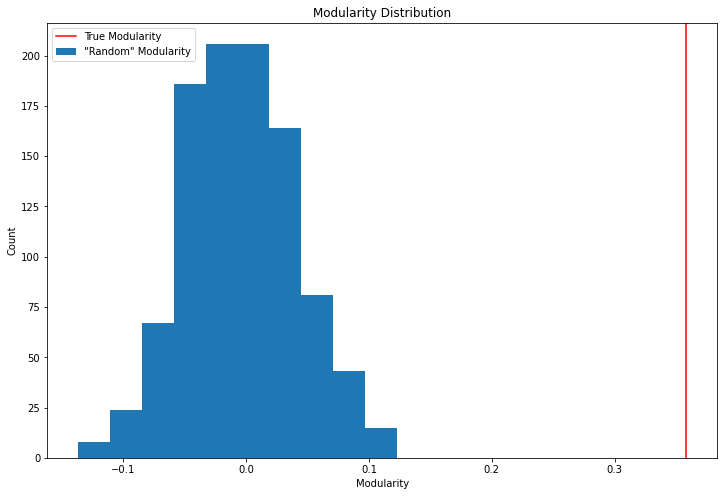

In [141]:
plt.figure(figsize=(12, 8))
plt.hist(modularity_list,label='"Random" Modularity')
plt.axvline(x=compute_modularity(G, 'group'),ymin=0,ymax=1, color='r',label='True Modularity')
plt.title('Modularity Distribution')
plt.xlabel('Modularity')
plt.ylabel('Count')
plt.legend()
plt.show()

Yes, the true split is a good split. This can be seen because the red line is on the far right of the x-axis. You asked us to do a randomized experiment to show us that random graphs lack the property of having good clusters as real graphs do. We have done 1000 random graphs and not a single graph has as high modularity as the true graph but it seems the randomized graphs have a modularity normally distributed around 0.

In [186]:
from community import community_louvain
# compute the best partition
partition = community_louvain.best_partition(G)
nx.set_node_attributes(G,partition,'parti')
print(compute_modularity(G, "parti"))
print(compute_modularity(G,"group"))

{0: 0, 1: 0, 2: 0, 3: 0, 4: 2, 5: 2, 6: 2, 7: 0, 8: 1, 9: 0, 10: 2, 11: 0, 12: 0, 13: 0, 14: 1, 15: 1, 16: 2, 17: 0, 18: 1, 19: 0, 20: 1, 21: 0, 22: 1, 23: 1, 24: 3, 25: 3, 26: 1, 27: 1, 28: 3, 29: 1, 30: 1, 31: 3, 32: 1, 33: 1}
0.4155982905982906
0.3582347140039447


The partitioned modularity is higher than the true modularity. This comparison reveals that the absolute best split according to the louvain algorithm is actually not found to be the true graph split. Instead it wants to split the data somehow else (actually into one big cluster)

In [179]:
of0 = 0
of1 = 0
of2 = 0
of3 = 0
hi0 = 0
hi1 = 0
hi2 = 0
hi3 = 0


for i in range(len(G.nodes())):
    if G.nodes[i]['parti'] == 0 and G.nodes[i]['group'] == 'Officer':
        of0 += 1
    if G.nodes[i]['parti'] == 1 and G.nodes[i]['group'] == 'Officer':
        of1 += 1
    if G.nodes[i]['parti'] == 2 and G.nodes[i]['group'] == 'Officer':
        of2 += 1
    if G.nodes[i]['parti'] == 3 and G.nodes[i]['group'] == 'Officer':
        of3 += 1
        
    if G.nodes[i]['parti'] == 0 and G.nodes[i]['group'] == 'Mr. Hi':
        hi0 += 1
    if G.nodes[i]['parti'] == 1 and G.nodes[i]['group'] == 'Mr. Hi':
        hi1 += 1
    if G.nodes[i]['parti'] == 2 and G.nodes[i]['group'] == 'Mr. Hi':
        hi2 += 1
    if G.nodes[i]['parti'] == 3 and G.nodes[i]['group'] == 'Mr. Hi':
        hi3 += 1

confusion_matrix = np.array([[of0,of1,of2,of3],[hi0,hi1,hi2,hi3]])
confusion_matrix

array([[ 0,  6,  0, 11],
       [11,  0,  5,  1]])

In [180]:
G.nodes[3]['group']

'Mr. Hi'

In [197]:
def prob_items(lis: list) -> dict:
    N = len(lis)
    dic = {}
    for i in list(dict.fromkeys(lis)):
        dic[i] = lis.count(i)/N
    return dic

In [198]:
prob_items([1,1,1,0,2])

{1: 0.6, 0: 0.2, 2: 0.2}

In [204]:
l1 = [G.nodes[i]['group'] for i in range(len(G.nodes()))]

In [205]:
prob_items(l1)

{'Mr. Hi': 0.5, 'Officer': 0.5}

In [206]:
l2 = [G.nodes[i]['parti'] for i in range(len(G.nodes()))]
prob_items(l2)

{0: 0.35294117647058826,
 2: 0.14705882352941177,
 1: 0.38235294117647056,
 3: 0.11764705882352941}

In [207]:
l3 = [(G.nodes[i]['group'],G.nodes[i]['parti']) for i in range(len(G.nodes()))]
prob_items(l3)

{('Mr. Hi', 0): 0.3235294117647059,
 ('Mr. Hi', 2): 0.14705882352941177,
 ('Mr. Hi', 1): 0.029411764705882353,
 ('Officer', 0): 0.029411764705882353,
 ('Officer', 1): 0.35294117647058826,
 ('Officer', 3): 0.11764705882352941}

In [274]:
px_club = prob_items(l1)
entropy_club = - sum(list(px_club.values()) * np.log(list(px_club.values())))
entropy_club

0.6931471805599453

In [275]:
px_louv = prob_items(l2)
entropy_louv = - sum(list(px_louv.values()) * np.log(list(px_louv.values())))
entropy_louv

1.2688432172306894

In [276]:
entropy = 0
for i in range(len(px_both)):
    entropy += list(px_both.items())[i][1] * np.log(list(px_both.items())[i][1] / px_louv[list(px_both.keys())[i][1]])

entropy = -1 * entropy
entropy

0.20492628371229119